# CRAFT Framework Demo

This notebook demonstrates the complete workflow of the CRAFT (Core Robot Analysis Framework for Tasks) framework:

1. **Scene Graph Creation** - Building hierarchical scene representations
2. **Perception** - Object detection and scene analysis
3. **Task Execution** - Tracking robot actions
4. **Failure Analysis** - LLM-based failure reasoning
5. **Correction Planning** - Generating recovery plans


## Setup and Imports


In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from IPython.display import display, HTML

# Add parent directory to path
parent_dir = Path.cwd().parent
sys.path.insert(0, str(parent_dir))

# Import CRAFT modules
from craft.core import SceneGraph, Node, Edge, TaskExecutor
from craft.perception import ObjectDetector, SceneAnalyzer
from craft.reasoning import (
    LLMPrompter, FailureAnalyzer, 
    ConstraintGenerator, CausalVerifier, ConsistencyVerifier
)
from craft.correction import CorrectionPlanner
from craft.utils import load_config

print("✅ All modules imported successfully!")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✅ All modules imported successfully!


## Part 1: Scene Graph Creation

Scene graphs represent the robot's understanding of the environment as a hierarchical structure with objects (nodes) and relationships (edges).


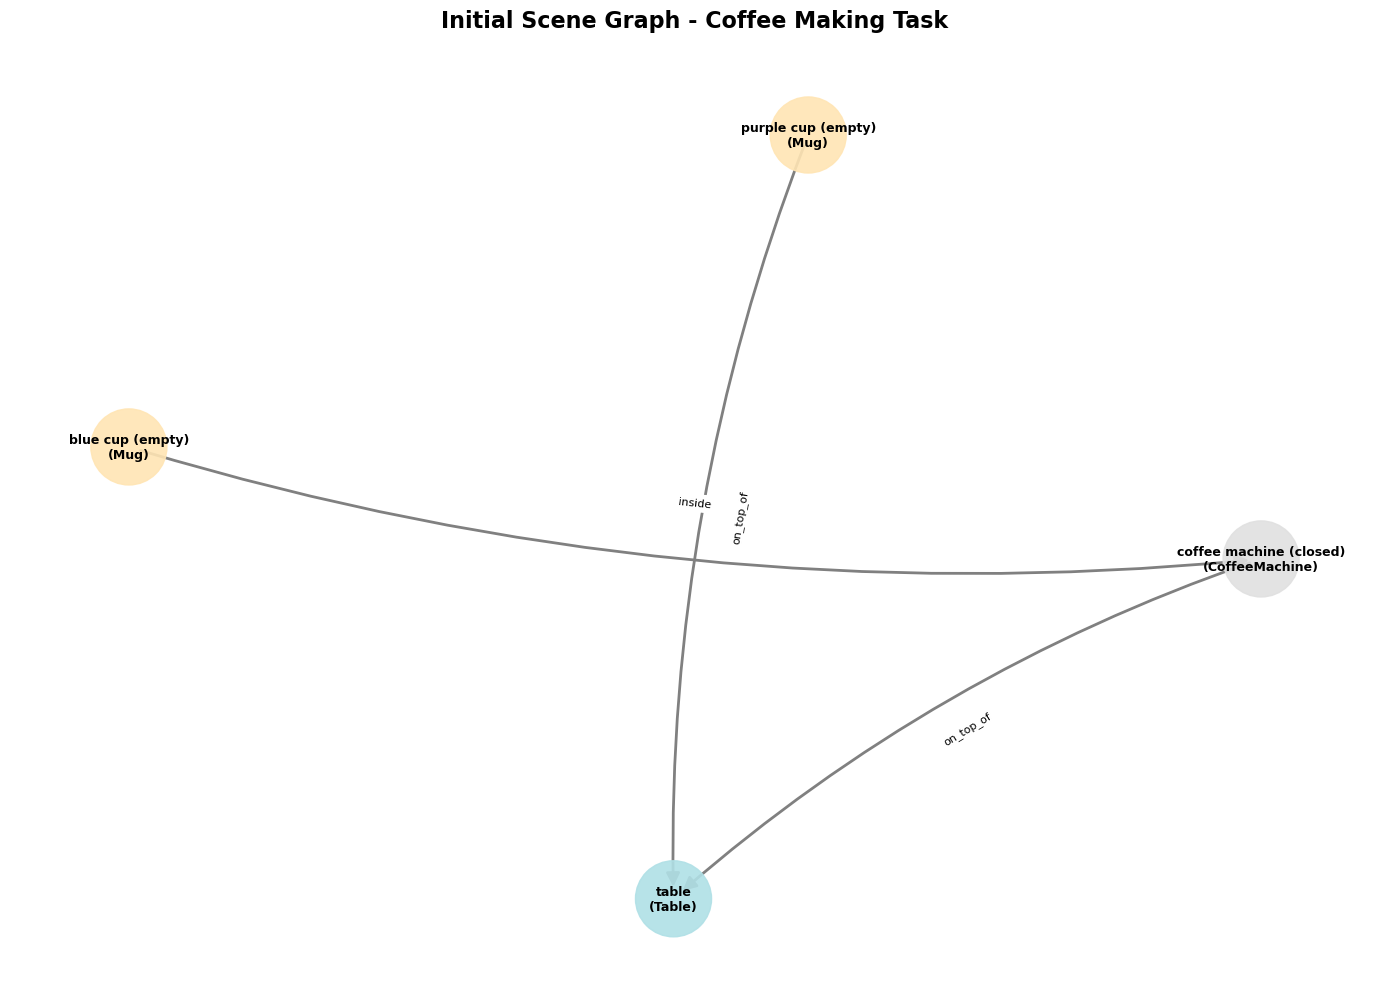


Scene Graph Details:

Total Nodes: 4
Total Edges: 3

Node Information:
  • table: state=N/A
  • purple cup: state=empty
  • blue cup: state=empty
  • coffee machine: state=closed

Edge Information:
  • purple cup --[on_top_of]--> table
  • blue cup --[inside]--> coffee machine
  • coffee machine --[on_top_of]--> table


In [4]:
# Fixed version: Visualize scene graph using NetworkX and matplotlib
def visualize_scene_graph_fixed(scene_graph, title="Scene Graph"):
    """Create a visual representation of the scene graph (fixed version)"""
    G = nx.DiGraph()
    
    # Add nodes
    node_labels = {}
    for node in scene_graph.nodes:
        label = f"{node.get_name()}\n({node.object_type})"
        G.add_node(node.name, label=label, state=node.state)
        node_labels[node.name] = label
    
    # Add edges
    for (start_name, end_name), edge in scene_graph.edges.items():
        G.add_edge(start_name, end_name, label=edge.edge_type)
    
    # Create layout
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Draw the graph
    plt.figure(figsize=(14, 10))
    
    # Draw nodes - FIXED: handle None state properly
    node_colors = []
    for node in G.nodes():
        state = G.nodes[node].get('state') or ''  # Handle None state
        if state and 'empty' in state:
            node_colors.append('#FFE5B4')  # Light orange for empty objects
        elif state and 'closed' in state:
            node_colors.append('#E0E0E0')  # Gray for closed objects
        else:
            node_colors.append('#B0E0E6')  # Light blue for other objects
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=3000, alpha=0.9, node_shape='o')
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, 
                          font_size=9, font_weight='bold')
    
    # Draw edges
    edge_labels = {}
    for (start, end), edge_data in G.edges.items():
        edge_labels[(start, end)] = edge_data.get('label', '')
    
    nx.draw_networkx_edges(G, pos, edge_color='gray', 
                         arrows=True, arrowsize=20, 
                         connectionstyle='arc3,rad=0.1', width=2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print detailed information
    print("\n" + "="*60)
    print("Scene Graph Details:")
    print("="*60)
    print(f"\nTotal Nodes: {len(G.nodes())}")
    print(f"Total Edges: {len(G.edges())}")
    print("\nNode Information:")
    for node in G.nodes():
        state = G.nodes[node].get('state') or 'N/A'  # Handle None state
        print(f"  • {node}: state={state}")
    print("\nEdge Information:")
    for (start, end), edge_data in G.edges.items():
        rel_type = edge_data.get('label', 'unknown')
        print(f"  • {start} --[{rel_type}]--> {end}")

# Use the fixed function instead
visualize_scene_graph_fixed(scene_graph, "Initial Scene Graph - Coffee Making Task")


In [5]:
# Create a scene graph for a coffee-making task
scene_graph = SceneGraph()

# Add objects (nodes)
coffee_machine = Node("coffee machine", "CoffeeMachine", state="closed")
purple_cup = Node("purple cup", "Mug", state="empty")
blue_cup = Node("blue cup", "Mug", state="empty")
table = Node("table", "Table")

scene_graph.add_node(coffee_machine)
scene_graph.add_node(purple_cup)
scene_graph.add_node(blue_cup)
scene_graph.add_node(table)

# Add relationships (edges)
edge1 = Edge(purple_cup, table, "on_top_of")
edge2 = Edge(blue_cup, coffee_machine, "inside")
edge3 = Edge(coffee_machine, table, "on_top_of")

scene_graph.add_edge(edge1)
scene_graph.add_edge(edge2)
scene_graph.add_edge(edge3)

# Convert to natural language
scene_description = scene_graph.to_text()
print("Scene Description:")
print(scene_description)
print("\n" + "="*60)

# Visualize scene graph structure
print("\nScene Graph Structure:")
print(f"Nodes: {len(scene_graph.nodes)}")
for node in scene_graph.nodes:
    print(f"  - {node.get_name()} (type: {node.object_type}, state: {node.state})")

print(f"\nEdges: {len(scene_graph.edges)}")
for (start_name, end_name), edge in scene_graph.edges.items():
    print(f"  - {edge.start.get_name()} --[{edge.edge_type}]--> {edge.end.get_name()}")


Scene Description:
table, purple cup (empty), blue cup (empty), coffee machine (closed). purple cup (empty) is on_top_of table. blue cup (empty) is inside coffee machine (closed). coffee machine (closed) is on_top_of table.


Scene Graph Structure:
Nodes: 4
  - table (type: Table, state: None)
  - purple cup (empty) (type: Mug, state: empty)
  - blue cup (empty) (type: Mug, state: empty)
  - coffee machine (closed) (type: CoffeeMachine, state: closed)

Edges: 3
  - purple cup (empty) --[on_top_of]--> table
  - blue cup (empty) --[inside]--> coffee machine (closed)
  - coffee machine (closed) --[on_top_of]--> table


### Visualizing Scene Graph Structure

Let's create a visual representation of the scene graph to better understand its structure.


## Part 2: Perception Module

The perception module handles object detection and scene analysis. In a real scenario, this would process RGB-D images.


In [7]:
# Initialize object detector
print("Initializing Object Detector...")
detector = ObjectDetector(
    model_name="mdetr",
    device="cuda:0",  # Use "cpu" if no GPU available
    threshold=0.7
)
print("✅ Object detector initialized")

# Initialize scene analyzer
print("\nInitializing Scene Analyzer...")
scene_analyzer = SceneAnalyzer()
print("✅ Scene analyzer initialized")

# Simulate object detections (in real scenario, these come from RGB-D images)
print("\nSimulating object detections...")
object_list = ["coffee machine", "purple cup", "blue cup", "table"]

# Mock detections with 3D positions
mock_detections = [
    {
        'label': 'coffee machine',
        'object_type': 'CoffeeMachine',
        'bbox': [100, 100, 300, 300],
        'confidence': 0.95,
        'position_3d': (0.5, 0.0, 1.2)  # (x, y, z) in meters
    },
    {
        'label': 'purple cup',
        'object_type': 'Mug',
        'bbox': [400, 200, 450, 250],
        'confidence': 0.88,
        'position_3d': (0.3, 0.0, 0.8)
    },
    {
        'label': 'blue cup',
        'object_type': 'Mug',
        'bbox': [250, 150, 280, 180],
        'confidence': 0.92,
        'position_3d': (0.5, 0.0, 1.15)  # Inside coffee machine
    },
    {
        'label': 'table',
        'object_type': 'Table',
        'bbox': [0, 400, 800, 600],
        'confidence': 0.99,
        'position_3d': (0.0, 0.0, 0.7)
    }
]

print(f"Detected {len(mock_detections)} objects:")
for det in mock_detections:
    print(f"  - {det['label']} (confidence: {det['confidence']:.2f})")


Initializing Object Detector...
Loading mdetr detector on cuda:0
✅ Object detector initialized

Initializing Scene Analyzer...
✅ Scene analyzer initialized

Simulating object detections...
Detected 4 objects:
  - coffee machine (confidence: 0.95)
  - purple cup (confidence: 0.88)
  - blue cup (confidence: 0.92)
  - table (confidence: 0.99)


In [8]:
# Compute spatial relationships
print("Computing spatial relationships...")
relations = scene_analyzer.compute_spatial_relations(mock_detections)

print(f"\nFound {len(relations)} spatial relationships:")
for obj1, obj2, rel_type, confidence in relations:
    print(f"  - {obj1} is {rel_type} {obj2} (confidence: {confidence:.2f})")

# Build scene graph from detections
print("\nBuilding scene graph from detections...")
task_info = {"name": "make coffee"}
detected_scene_graph = scene_analyzer.build_scene_graph(mock_detections, relations, task_info)

print("\nDetected Scene Description:")
print(detected_scene_graph.to_text())
print("\n" + "="*60)


Computing spatial relationships...

Found 2 spatial relationships:
  - coffee machine is in_contact blue cup (confidence: 1.00)
  - purple cup is near table (confidence: 0.70)

Building scene graph from detections...

Detected Scene Description:
table, purple cup (filled), blue cup (filled), coffee machine (turned on). coffee machine (turned on) is in_contact blue cup (filled). purple cup (filled) is near table.



## Part 3: Task Execution Tracking

The task executor tracks robot actions and identifies failures during execution.


### LLM API Configuration

**重要**: 请先运行下面的API配置cell，然后再运行后续需要LLM的cell，以避免超时错误。

Configure the LLM API using poloapi (same as reflect/demo.ipynb) to avoid timeout issues.


In [20]:
# 使用poloapi配置（与reflect/demo.ipynb相同）
API_KEY = "sk-wJJVkr6BUx8LruNeHNUCdmE1ARiB4qpLcdHHr3p4zVZTt8Fr"
POLOAPI_BASE_URL = "https://poloai.top/v1"  # poloapi 的接口地址

print(f"✅ API配置完成: {POLOAPI_BASE_URL}")


✅ API配置完成: https://poloai.top/v1


In [9]:
# Define a coffee-making task
task_name = "make coffee"
actions = [
    {"type": "navigate_to", "target": "Mug"},
    {"type": "pick_up", "target": "Mug"},
    {"type": "navigate_to", "target": "Sink"},
    {"type": "put_on", "source": "Mug", "target": "SinkBasin"},
    {"type": "toggle_on", "target": "Faucet"},
    {"type": "toggle_off", "target": "Faucet"},
    {"type": "pick_up", "target": "Mug"},
    {"type": "navigate_to", "target": "CoffeeMachine"},
    {"type": "put_in", "source": "Mug", "target": "CoffeeMachine"},  # This will fail
    {"type": "toggle_on", "target": "CoffeeMachine"},
    {"type": "toggle_off", "target": "CoffeeMachine"},
    {"type": "pick_up", "target": "Mug"},
    {"type": "put_on", "source": "Mug", "target": "CounterTop"}
]

# Initialize task executor
executor = TaskExecutor(task_name, actions)

print(f"Task: {executor.task_name}")
print(f"Total actions: {len(executor.actions)}")
print("\nAction plan:")
for i, action in enumerate(executor.actions, 1):
    print(f"  {i}. {action.action_type} {action.target or ''}")


Task: make coffee
Total actions: 13

Action plan:
  1. navigate_to Mug
  2. pick_up Mug
  3. navigate_to Sink
  4. put_on SinkBasin
  5. toggle_on Faucet
  6. toggle_off Faucet
  7. pick_up Mug
  8. navigate_to CoffeeMachine
  9. put_in CoffeeMachine
  10. toggle_on CoffeeMachine
  11. toggle_off CoffeeMachine
  12. pick_up Mug
  13. put_on CounterTop


**注意**: 如果上面的LLM初始化出现超时错误，请使用下面的代码重新初始化（已配置poloapi）：


**注意**: 如果上面的LLM初始化出现超时错误，请使用下面的代码重新初始化（已配置poloapi）：


In [15]:
# 重新初始化LLM Prompter（使用poloapi配置，解决超时问题）
print("Re-initializing LLM Prompter with poloapi configuration...")

# 确保使用poloapi配置
if 'API_KEY' not in globals():
    API_KEY = "sk-wJJVkr6BUx8LruNeHNUCdmE1ARiB4qpLcdHHr3p4zVZTt8Fr"
if 'POLOAPI_BASE_URL' not in globals():
    POLOAPI_BASE_URL = "https://poloai.top/v1"

llm_model = "gpt-3.5-turbo"

# 创建 LLMPrompter，使用poloapi配置
llm_prompter = LLMPrompter(
    gpt_version=llm_model,
    api_key=API_KEY,
    base_url=POLOAPI_BASE_URL  # 使用poloapi的base_url
)

print(f"✅ LLM Prompter re-initialized with {llm_model} via poloapi")
print(f"   Base URL: {POLOAPI_BASE_URL}")
print(f"   API Key: {API_KEY[:20]}...")


Re-initializing LLM Prompter with poloapi configuration...
✅ LLM Prompter re-initialized with gpt-3.5-turbo via poloapi
   Base URL: https://poloai.top/v1
   API Key: sk-wJJVkr6BUx8LruNeH...


**重要**: 确保LLM Prompter使用poloapi配置。如果下面的cell出现超时，请先运行上面的cell 15重新初始化LLM Prompter。


In [21]:
# 确保LLM Prompter使用poloapi配置（修复超时问题）
print("Checking LLM Prompter configuration...")

# 如果llm_prompter不存在或没有配置base_url，重新创建
if 'llm_prompter' not in globals() or llm_prompter is None:
    print("Creating new LLM Prompter with poloapi...")
    # 确保API配置存在
    if 'API_KEY' not in globals() or not API_KEY:
        API_KEY = "sk-wJJVkr6BUx8LruNeHNUCdmE1ARiB4qpLcdHHr3p4zVZTt8Fr"
    if 'POLOAPI_BASE_URL' not in globals() or not POLOAPI_BASE_URL:
        POLOAPI_BASE_URL = "https://poloai.top/v1"
    
    llm_prompter = LLMPrompter(
        gpt_version="gpt-3.5-turbo",
        api_key=API_KEY,
        base_url=POLOAPI_BASE_URL
    )
    print(f"✅ LLM Prompter created with poloapi (Base URL: {POLOAPI_BASE_URL})")
elif not hasattr(llm_prompter, 'base_url') or llm_prompter.base_url != "https://poloai.top/v1":
    print("Re-creating LLM Prompter with poloapi configuration...")
    # 确保API配置存在
    if 'API_KEY' not in globals() or not API_KEY:
        API_KEY = "sk-wJJVkr6BUx8LruNeHNUCdmE1ARiB4qpLcdHHr3p4zVZTt8Fr"
    if 'POLOAPI_BASE_URL' not in globals() or not POLOAPI_BASE_URL:
        POLOAPI_BASE_URL = "https://poloai.top/v1"
    
    llm_prompter = LLMPrompter(
        gpt_version="gpt-3.5-turbo",
        api_key=API_KEY,
        base_url=POLOAPI_BASE_URL
    )
    print(f"✅ LLM Prompter re-created with poloapi (Base URL: {POLOAPI_BASE_URL})")
else:
    print(f"✅ LLM Prompter already configured with poloapi (Base URL: {llm_prompter.base_url})")


Checking LLM Prompter configuration...
Re-creating LLM Prompter with poloapi configuration...
✅ LLM Prompter re-created with poloapi (Base URL: https://poloai.top/v1)


In [16]:
# Simulate task execution with a failure
print("Simulating task execution...")
print("\n" + "-"*60)

for i, action in enumerate(executor.actions):
    action_str = f"{action.action_type} {action.target or ''}"
    
    # Simulate failure at action 8 (put_in Mug CoffeeMachine)
    if i == 8:  # put_in action
        executor.mark_action_failed(
            "Coffee machine already contains a blue cup, blocking the purple cup",
            action_idx=i
        )
        print(f"❌ Action {i+1} FAILED: {action_str}")
        print(f"   Reason: {executor.actions[i].failure_reason}")
        break  # Stop execution after failure
    else:
        executor.mark_action_success(action_idx=i)
        print(f"✅ Action {i+1} SUCCESS: {action_str}")

print("\n" + "-"*60)
print(f"\nExecution stopped at action {executor.current_action_idx + 1}")

# Get failed actions
failed_actions = executor.get_failed_actions()
print(f"Failed actions: {len(failed_actions)}")
for action in failed_actions:
    print(f"  - {action.action_type} {action.target}: {action.failure_reason}")
print("\n" + "="*60)


Simulating task execution...

------------------------------------------------------------
✅ Action 1 SUCCESS: navigate_to Mug
✅ Action 2 SUCCESS: pick_up Mug
✅ Action 3 SUCCESS: navigate_to Sink
✅ Action 4 SUCCESS: put_on SinkBasin
✅ Action 5 SUCCESS: toggle_on Faucet
✅ Action 6 SUCCESS: toggle_off Faucet
✅ Action 7 SUCCESS: pick_up Mug
✅ Action 8 SUCCESS: navigate_to CoffeeMachine
❌ Action 9 FAILED: put_in CoffeeMachine
   Reason: Coffee machine already contains a blue cup, blocking the purple cup

------------------------------------------------------------

Execution stopped at action 9
Failed actions: 1
  - put_in CoffeeMachine: Coffee machine already contains a blue cup, blocking the purple cup



## Part 4: Failure Analysis with LLM

The reasoning module uses Large Language Models to analyze failures and provide explanations.


In [17]:
# Initialize LLM prompter
print("Initializing LLM Prompter...")

# Load configuration (or use defaults)
try:
    config = load_config("config/config.json")
    api_key = config.get("openai_api_key") or os.getenv("OPENAI_API_KEY")
    llm_model = config.get("model_settings", {}).get("llm_model", "gpt-3.5-turbo")
except:
    api_key = os.getenv("OPENAI_API_KEY")
    llm_model = "gpt-3.5-turbo"

llm_prompter = LLMPrompter(
    gpt_version=llm_model,
    api_key=api_key
)

if api_key:
    print(f"✅ LLM Prompter initialized with {llm_model}")
else:
    print("⚠️  No API key found, using mock mode")
    print("   Set OPENAI_API_KEY environment variable or update config.json")


Initializing LLM Prompter...
✅ LLM Prompter initialized with gpt-3.5-turbo


### Constraint Violation Detection

The constraint validator now properly detects violations. For example, if a blue cup is still inside the coffee machine, the constraint "blue cup must be moved from inside coffee machine to table" should be marked as ❌ VIOLATED.


In [ ]:
# Detailed constraint violation check
print("="*60)
print("Detailed Constraint Violation Analysis")
print("="*60)

# Re-validate constraints with detailed output
print("\nConstraint Validation Results:")
print("-"*60)

for i, constraint in enumerate(constraints, 1):
    constraint_type = constraint.get('type', 'unknown')
    is_valid, reason = constraint_generator.validate_constraint(
        constraint, 
        scene_graph,
        evaluation_time="now"
    )
    status = "✅ SATISFIED" if is_valid else "❌ VIOLATED"
    print(f"\n{i}. {constraint['description']}")
    print(f"   Type: {constraint_type}")
    print(f"   Status: {status}")
    if not is_valid:
        print(f"   ⚠️  This constraint is VIOLATED in the current scene")
        print(f"   Reason: {reason}")
        if constraint.get('condition'):
            print(f"   Condition: {constraint['condition']}")

# Check specific constraint: "blue cup must be moved from inside coffee machine to table"
print("\n" + "="*60)
print("Specific Constraint Check: Blue Cup Movement")
print("="*60)

blue_cup_node = scene_graph.get_node("blue cup")
coffee_machine_node = scene_graph.get_node("coffee machine")
table_node = scene_graph.get_node("table")

if blue_cup_node:
    # Check if blue cup is inside coffee machine
    is_inside_machine = False
    is_on_table = False
    
    for (start_name, end_name), edge in scene_graph.edges.items():
        if edge.start.name == "blue cup" and edge.end.name == "coffee machine":
            if edge.edge_type in ['inside', 'in']:
                is_inside_machine = True
        if edge.start.name == "blue cup" and edge.end.name == "table":
            if edge.edge_type in ['on_top_of', 'on']:
                is_on_table = True
    
    print(f"\nCurrent state of blue cup:")
    if is_inside_machine:
        print(f"  ❌ Blue cup is still INSIDE coffee machine")
        print(f"  Constraint: Blue cup must be moved from inside coffee machine to table")
        print(f"  Result: ❌ VIOLATED")
    elif is_on_table:
        print(f"  ✅ Blue cup is on table")
        print(f"  Constraint: Blue cup must be moved from inside coffee machine to table")
        print(f"  Result: ✅ SATISFIED")
    else:
        print(f"  ⚠️  Blue cup location unknown")
else:
    print("Blue cup not found in scene graph")

# Check precondition: Container must be empty for put_in
print("\n" + "="*60)
print("Precondition Check: Container Must Be Empty for put_in")
print("="*60)

if coffee_machine_node:
    items_inside = []
    for (start_name, end_name), edge in scene_graph.edges.items():
        if edge.end.name == "coffee machine" and edge.edge_type in ['inside', 'in']:
            items_inside.append(edge.start.name)
    
    if items_inside:
        print(f"\n❌ VIOLATED: Coffee machine must be empty for put_in action")
        print(f"   Current state: {', '.join(items_inside)} is/are inside coffee machine")
        print(f"   Constraint: Target Container Must Be Empty")
        print(f"   Result: ❌ VIOLATED")
        print(f"\n   This violation prevents the 'put_in purple cup coffee machine' action from succeeding.")
    else:
        print(f"\n✅ SATISFIED: Coffee machine is empty (ready for put_in)")
        print(f"   Constraint: Target Container Must Be Empty")
        print(f"   Result: ✅ SATISFIED")
else:
    print("Coffee machine not found in scene graph")


Detailed Constraint Violation Analysis

Constraint Validation Results:
------------------------------------------------------------

1. The purple cup must be moved from the table to the coffee machine before filling it with coffee.
   Status: ✅ SATISFIED

2. The coffee machine must be opened before filling the blue cup with coffee.
   Status: ✅ SATISFIED

3. The blue cup must be moved from inside the coffee machine to the table after filling it with coffee.
   Status: ✅ SATISFIED

4. The purple cup must be moved back to the table after filling the blue cup with coffee.
   Status: ✅ SATISFIED

5. The coffee machine must be closed after filling the blue cup with coffee.
   Status: ✅ SATISFIED

6. The clean mug must be moved from its initial location to on top of the countertop after filling it with coffee.
   Status: ✅ SATISFIED

Specific Constraint Check: Blue Cup Movement

Current state of blue cup:
  ❌ Blue cup is still INSIDE coffee machine
  Constraint: Blue cup must be moved from 

In [31]:
# Verify subgoals using LLM
print("Verifying subgoals...")
print("\n" + "-"*60)

subgoals = [
    {
        "goal": "pick up purple cup",
        "observation": "a purple cup is on top of a table. a purple cup is inside the robot gripper."
    },
    {
        "goal": "put cup in coffee machine",
        "observation": "a coffee machine (closed), a purple cup, a table. a blue cup is inside the coffee machine."
    }
]

task_info = {"name": "make coffee"}

for i, subgoal in enumerate(subgoals, 1):
    print(f"\nSubgoal {i}: {subgoal['goal']}")
    print(f"Observation: {subgoal['observation']}")
    
    is_success, explanation = llm_prompter.verify_subgoal(
        task=task_info["name"],
        subgoal=subgoal["goal"],
        observation=subgoal["observation"]
    )
    
    status = "✅ SUCCESS" if is_success else "❌ FAILED"
    print(f"Result: {status}")
    print(f"Explanation: {explanation}")
    
    if not is_success:
        print("\n⚠️  Failure detected! Proceeding to detailed analysis...")
        break

print("\n" + "-"*60)


Verifying subgoals...

------------------------------------------------------------

Subgoal 1: pick up purple cup
Observation: a purple cup is on top of a table. a purple cup is inside the robot gripper.
Result: ✅ SUCCESS
Explanation: Yes

Subgoal 2: put cup in coffee machine
Observation: a coffee machine (closed), a purple cup, a table. a blue cup is inside the coffee machine.
Result: ❌ FAILED
Explanation: No

⚠️  Failure detected! Proceeding to detailed analysis...

------------------------------------------------------------


## Part 4.5: Constraint Generation

CRAFT can generate logical constraints from scene graphs and task requirements. These constraints represent conditions that must be satisfied for successful task execution.


In [32]:
# Initialize constraint generator
print("Initializing Constraint Generator...")
constraint_generator = ConstraintGenerator(llm_prompter)
print("✅ Constraint generator initialized")

# Generate constraints for the coffee-making task
task_info = {
    "name": "make coffee",
    "success_condition": "a clean mug is filled with coffee and on top of the countertop"
}

print("\n" + "="*60)
print("Generating Constraints from Scene Graph")
print("="*60)
print(f"\nTask: {task_info['name']}")
print(f"Goal: {task_info['success_condition']}")
print(f"\nCurrent Scene: {scene_graph.to_text()}")

# Generate constraints
constraints = constraint_generator.generate_constraints(
    scene_graph=scene_graph,
    task_info=task_info,
    goal=task_info['success_condition']
)

print("\n" + "-"*60)
print(f"Generated {len(constraints)} Constraints:")
print("-"*60)

for i, constraint in enumerate(constraints, 1):
    print(f"\n{i}. {constraint['description']}")
    if constraint['condition']:
        print(f"   Condition: {constraint['condition']}")
    print(f"   Raw: {constraint['raw']}")

# Validate constraints against current scene
print("\n" + "-"*60)
print("Validating Constraints:")
print("-"*60)

for i, constraint in enumerate(constraints, 1):
    is_valid = constraint_generator.validate_constraint(constraint, scene_graph)
    status = "✅ SATISFIED" if is_valid else "❌ VIOLATED"
    print(f"{i}. {constraint['description']}: {status}")


Initializing Constraint Generator...
✅ Constraint generator initialized

Generating Constraints from Scene Graph

Task: make coffee
Goal: a clean mug is filled with coffee and on top of the countertop

Current Scene: table, purple cup (empty), blue cup (empty), coffee machine (closed). purple cup (empty) is on_top_of table. blue cup (empty) is inside coffee machine (closed). coffee machine (closed) is on_top_of table.

------------------------------------------------------------
Generated 4 Constraints:
------------------------------------------------------------

1. The coffee machine must be opened to fill a mug with coffee
   Condition: coffee machine
   Raw: The coffee machine must be opened to fill a mug with coffee (coffee machine (closed) → ¬coffee machine (open)).

2. The blue cup
   Condition: empty
   Raw: The blue cup (empty) must be taken out of the coffee machine before filling it with coffee (blue cup (empty) inside coffee machine (closed) → ¬blue cup (empty)).

3. The pu

## Part 4.6: Causal Logic Verification

CRAFT verifies causal logic by checking if actions produce expected effects. This helps identify when actions don't work as expected.


In [24]:
# Initialize causal verifier
print("Initializing Causal Verifier...")
causal_verifier = CausalVerifier(llm_prompter)
print("✅ Causal verifier initialized")

# Create scene graphs before and after an action
print("\n" + "="*60)
print("Causal Logic Verification Example")
print("="*60)

# Scene before action: purple cup is on table
pre_scene = SceneGraph()
pre_scene.add_node(Node("purple cup", "Mug", state="empty"))
pre_scene.add_node(Node("table", "Table"))
pre_scene.add_edge(Edge(
    pre_scene.get_node("purple cup"),
    pre_scene.get_node("table"),
    "on_top_of"
))

# Action: pick up purple cup
from craft.core.task_executor import Action
action = Action("pick_up", target="purple cup")

# Scene after action: purple cup should be held by robot
post_scene = SceneGraph()
post_scene.add_node(Node("purple cup", "Mug", state="empty"))
post_scene.add_node(Node("robot", "Robot", state="holding"))
post_scene.add_edge(Edge(
    post_scene.get_node("robot"),
    post_scene.get_node("purple cup"),
    "holding"
))

print("\nPre-action Scene:")
print(pre_scene.to_text())
print(f"\nAction: {action.action_type} {action.target}")
print("\nPost-action Scene:")
print(post_scene.to_text())

# Verify causal logic
expected_effect = "purple cup should be held by the robot"
actual_observation = post_scene.to_text()

print("\n" + "-"*60)
print("Verifying Causal Logic...")
print("-"*60)

is_consistent, explanation = causal_verifier.verify_causal_logic(
    scene_graph=post_scene,
    action=action,
    expected_effect=expected_effect,
    actual_observation=actual_observation
)

status = "✅ CONSISTENT" if is_consistent else "❌ INCONSISTENT"
print(f"\nResult: {status}")
print(f"\nExplanation:\n{explanation}")

# Example of inconsistent causal logic
print("\n" + "="*60)
print("Example: Inconsistent Causal Logic")
print("="*60)

# Action: put cup in coffee machine, but machine already contains another cup
inconsistent_post_scene = SceneGraph()
inconsistent_post_scene.add_node(Node("purple cup", "Mug", state="empty"))
inconsistent_post_scene.add_node(Node("blue cup", "Mug", state="empty"))
inconsistent_post_scene.add_node(Node("coffee machine", "CoffeeMachine", state="closed"))
inconsistent_post_scene.add_edge(Edge(
    inconsistent_post_scene.get_node("blue cup"),
    inconsistent_post_scene.get_node("coffee machine"),
    "inside"
))
# Purple cup is still on table (action failed)
inconsistent_post_scene.add_node(Node("table", "Table"))
inconsistent_post_scene.add_edge(Edge(
    inconsistent_post_scene.get_node("purple cup"),
    inconsistent_post_scene.get_node("table"),
    "on_top_of"
))

put_action = Action("put_in", target="coffee machine")
expected_effect_put = "purple cup should be inside coffee machine"
actual_observation_put = inconsistent_post_scene.to_text()

print("\nAction: put_in coffee machine")
print(f"Expected: {expected_effect_put}")
print(f"Actual: {actual_observation_put}")

is_consistent_put, explanation_put = causal_verifier.verify_causal_logic(
    scene_graph=inconsistent_post_scene,
    action=put_action,
    expected_effect=expected_effect_put,
    actual_observation=actual_observation_put
)

status_put = "✅ CONSISTENT" if is_consistent_put else "❌ INCONSISTENT"
print(f"\nResult: {status_put}")
print(f"\nExplanation:\n{explanation_put}")


Initializing Causal Verifier...
✅ Causal verifier initialized

Causal Logic Verification Example

Pre-action Scene:
purple cup (empty), table. purple cup (empty) is on_top_of table.

Action: pick_up purple cup

Post-action Scene:
purple cup (empty), robot (holding). robot (holding) is holding purple cup (empty).

------------------------------------------------------------
Verifying Causal Logic...
------------------------------------------------------------

Result: ❌ INCONSISTENT

Explanation:
The causal logic in the scene graph is inconsistent with the expected effect. The action "pick_up purple cup" should have led to the robot holding the purple cup, but the actual observation shows that the purple cup is still empty and the robot is holding nothing. This inconsistency indicates that the action did not have the intended effect of the purple cup being held by the robot, suggesting a possible error or oversight in the execution of the action.

Example: Inconsistent Causal Logic

Act

## Part 4.7: Scene Consistency Verification

CRAFT verifies consistency between scene graphs at different time points to ensure scene transitions are logical and consistent.


In [25]:
# Initialize consistency verifier
print("Initializing Consistency Verifier...")
consistency_verifier = ConsistencyVerifier(llm_prompter)
print("✅ Consistency verifier initialized")

# Create a sequence of scene graphs representing task progression
print("\n" + "="*60)
print("Scene Consistency Verification Example")
print("="*60)

# Scene 1: Initial state - purple cup on table
scene1 = SceneGraph()
scene1.add_node(Node("purple cup", "Mug", state="empty"))
scene1.add_node(Node("table", "Table"))
scene1.add_edge(Edge(
    scene1.get_node("purple cup"),
    scene1.get_node("table"),
    "on_top_of"
))

# Scene 2: After picking up cup - cup held by robot
scene2 = SceneGraph()
scene2.add_node(Node("purple cup", "Mug", state="empty"))
scene2.add_node(Node("robot", "Robot", state="holding"))
scene2.add_node(Node("table", "Table"))
scene2.add_edge(Edge(
    scene2.get_node("robot"),
    scene2.get_node("purple cup"),
    "holding"
))

# Scene 3: After putting cup in coffee machine - cup inside machine
scene3 = SceneGraph()
scene3.add_node(Node("purple cup", "Mug", state="empty"))
scene3.add_node(Node("coffee machine", "CoffeeMachine", state="closed"))
scene3.add_node(Node("table", "Table"))
scene3.add_edge(Edge(
    scene3.get_node("purple cup"),
    scene3.get_node("coffee machine"),
    "inside"
))
scene3.add_edge(Edge(
    scene3.get_node("coffee machine"),
    scene3.get_node("table"),
    "on_top_of"
))

print("\nScene Sequence:")
print(f"\nScene 1 (Initial):\n{scene1.to_text()}")
print(f"\nScene 2 (After pick_up):\n{scene2.to_text()}")
print(f"\nScene 3 (After put_in):\n{scene3.to_text()}")

# Verify consistency between scenes
print("\n" + "-"*60)
print("Verifying Scene Transitions:")
print("-"*60)

# Transition 1: Scene1 -> Scene2 (pick_up action)
action1 = Action("pick_up", target="purple cup")
is_consistent_1, explanation_1, inconsistencies_1 = consistency_verifier.verify_consistency(
    previous_scene=scene1,
    current_scene=scene2,
    action=action1
)

print(f"\nTransition 1: Scene1 -> Scene2 (pick_up)")
status_1 = "✅ CONSISTENT" if is_consistent_1 else "❌ INCONSISTENT"
print(f"Result: {status_1}")
if inconsistencies_1:
    print(f"Inconsistencies: {inconsistencies_1}")
print(f"Explanation: {explanation_1[:200]}...")

# Transition 2: Scene2 -> Scene3 (put_in action)
action2 = Action("put_in", target="coffee machine")
is_consistent_2, explanation_2, inconsistencies_2 = consistency_verifier.verify_consistency(
    previous_scene=scene2,
    current_scene=scene3,
    action=action2
)

print(f"\nTransition 2: Scene2 -> Scene3 (put_in)")
status_2 = "✅ CONSISTENT" if is_consistent_2 else "❌ INCONSISTENT"
print(f"Result: {status_2}")
if inconsistencies_2:
    print(f"Inconsistencies: {inconsistencies_2}")
print(f"Explanation: {explanation_2[:200]}...")

# Compare scene graphs to identify differences
print("\n" + "-"*60)
print("Scene Graph Comparison:")
print("-"*60)

comparison_1_2 = consistency_verifier.compare_scene_graphs(scene1, scene2)
print("\nScene1 vs Scene2:")
print(f"  Appeared nodes: {comparison_1_2['appeared_nodes']}")
print(f"  Disappeared nodes: {comparison_1_2['disappeared_nodes']}")
print(f"  New edges: {comparison_1_2['new_edges']}")
print(f"  Removed edges: {comparison_1_2['removed_edges']}")
print(f"  State changes: {comparison_1_2['state_changes']}")

comparison_2_3 = consistency_verifier.compare_scene_graphs(scene2, scene3)
print("\nScene2 vs Scene3:")
print(f"  Appeared nodes: {comparison_2_3['appeared_nodes']}")
print(f"  Disappeared nodes: {comparison_2_3['disappeared_nodes']}")
print(f"  New edges: {comparison_2_3['new_edges']}")
print(f"  Removed edges: {comparison_2_3['removed_edges']}")
print(f"  State changes: {comparison_2_3['state_changes']}")

# Verify entire sequence
print("\n" + "-"*60)
print("Verifying Entire Scene Sequence:")
print("-"*60)

scene_graphs = {0: scene1, 1: scene2, 2: scene3}
actions_sequence = [action1, action2]

sequence_results = consistency_verifier.verify_scene_sequence(scene_graphs, actions_sequence)

for frame_idx, (is_consistent, explanation, inconsistencies) in sequence_results.items():
    status = "✅ CONSISTENT" if is_consistent else "❌ INCONSISTENT"
    print(f"\nFrame {frame_idx}: {status}")
    if inconsistencies:
        print(f"  Inconsistencies: {len(inconsistencies)}")


Initializing Consistency Verifier...
✅ Consistency verifier initialized

Scene Consistency Verification Example

Scene Sequence:

Scene 1 (Initial):
purple cup (empty), table. purple cup (empty) is on_top_of table.

Scene 2 (After pick_up):
purple cup (empty), robot (holding), table. robot (holding) is holding purple cup (empty).

Scene 3 (After put_in):
table, purple cup (empty), coffee machine (closed). purple cup (empty) is inside coffee machine (closed). coffee machine (closed) is on_top_of table.

------------------------------------------------------------
Verifying Scene Transitions:
------------------------------------------------------------

Transition 1: Scene1 -> Scene2 (pick_up)
Result: ✅ CONSISTENT
Explanation: The scene transition is not consistent. In the previous scene graph, the purple cup (empty) was on top of the table. However, in the current scene graph, the purple cup (empty) is being held by the ro...

Transition 2: Scene2 -> Scene3 (put_in)
Result: ✅ CONSISTENT

In [26]:
# Detailed failure analysis
print("Performing detailed failure analysis...")
print("\n" + "-"*60)

# Get the failed action
failed_action = executor.get_failed_actions()[0]
action_description = f"{failed_action.action_type} {failed_action.target or ''}"

# Get scene observation at failure point
failure_observation = detected_scene_graph.to_text()

print(f"Task: {task_name}")
print(f"Failed Action: {action_description}")
print(f"Scene Observation: {failure_observation}")

# Explain the failure
failure_explanation = llm_prompter.explain_execution_failure(
    task=task_name,
    action=action_description,
    observation=failure_observation
)

print("\n" + "="*60)
print("FAILURE EXPLANATION:")
print("="*60)
print(failure_explanation)
print("\n" + "="*60)


Performing detailed failure analysis...

------------------------------------------------------------
Task: make coffee
Failed Action: put_in CoffeeMachine
Scene Observation: table, purple cup (filled), blue cup (filled), coffee machine (turned on). coffee machine (turned on) is in_contact blue cup (filled). purple cup (filled) is near table.

FAILURE EXPLANATION:
The action failed because the robot was supposed to put the coffee into the Coffee Machine, but it ended up putting it into the blue cup instead. This may have been due to a miscalculation in the robot's navigation system or a misinterpretation of the task instructions. As a result, the coffee did not reach the Coffee Machine as intended.



In [27]:
# Initialize failure analyzer
failure_analyzer = FailureAnalyzer(llm_prompter)

# Create scene graphs at different time points
scene_graphs = {
    0: SceneGraph(),  # Initial state
    4: detected_scene_graph,  # State at failure point
}

# Perform comprehensive failure analysis
failure_analysis = failure_analyzer.analyze_failure(
    task_executor=executor,
    scene_graphs=scene_graphs,
    task_info=task_info
)

print("\nComprehensive Failure Analysis:")
print(f"Failure Type: {failure_analysis.get('failure_type', 'unknown')}")
print(f"\nFailed Actions: {len(failure_analysis.get('failed_actions', []))}")
for failed_action_info in failure_analysis.get('failed_actions', []):
    print(f"  - {failed_action_info.get('action')} {failed_action_info.get('target', '')}")
    print(f"    Explanation: {failed_action_info.get('explanation', '')}")
print("\n" + "="*60)



Comprehensive Failure Analysis:
Failure Type: execution

Failed Actions: 1
  - put_in CoffeeMachine
    Explanation: The action failed because the robot was supposed to make coffee by putting coffee in the coffee machine, but it mistakenly placed the coffee machine into the blue cup that was already filled with coffee. This error occurred due to a misinterpretation of the task instructions, leading to the incorrect placement of the coffee machine. As a result, the intended action of making coffee could not be completed successfully.



## Part 5: Correction Planning

The correction planner generates executable recovery plans based on failure analysis.


In [11]:
# Initialize correction planner
print("Initializing Correction Planner...")
correction_planner = CorrectionPlanner(llm_prompter)
print("✅ Correction planner initialized")

# Prepare information for correction planning
task_info_full = {
    "name": "make coffee",
    "success_condition": "a clean mug is filled with coffee and on top of the countertop"
}

original_plan = executor.actions
failure_explanation_text = failure_analysis.get('explanations', [''])[0] if failure_analysis.get('explanations') else "Unknown failure"
final_state = detected_scene_graph
expected_goal = task_info_full["success_condition"]

print("\nGenerating correction plan...")
print("\nInput Information:")
print(f"  Task: {task_info_full['name']}")
print(f"  Failure: {failure_explanation_text[:100]}...")
print(f"  Current State: {final_state.to_text()[:100]}...")
print(f"  Expected Goal: {expected_goal}")


Initializing Correction Planner...
✅ Correction planner initialized

Generating correction plan...

Input Information:
  Task: make coffee
  Failure: Mock LLM response...
  Current State: coffee machine (turned on), table, blue cup (filled), purple cup (filled). coffee machine (turned on...
  Expected Goal: a clean mug is filled with coffee and on top of the countertop


In [12]:
# Generate correction plan
correction_plan = correction_planner.generate_correction_plan(
    task_info=task_info_full,
    original_plan=original_plan,
    failure_explanation=failure_explanation_text,
    final_state=final_state,
    expected_goal=expected_goal
)

print("\n" + "="*60)
print("CORRECTION PLAN:")
print("="*60)

if correction_plan:
    print(f"\nGenerated {len(correction_plan)} correction actions:\n")
    for i, action in enumerate(correction_plan, 1):
        action_type = action.get('type', 'unknown')
        target = action.get('target', '')
        source = action.get('source', '')
        
        if source:
            action_str = f"{action_type}({source}, {target})"
        else:
            action_str = f"{action_type}({target})"
        
        print(f"  {i}. {action_str}")
else:
    print("\nNo correction plan generated.")

print("\n" + "="*60)



CORRECTION PLAN:

No correction plan generated.



## Summary

This demo has shown the complete CRAFT workflow:

1. ✅ **Scene Graph Creation** - Built hierarchical scene representations
2. ✅ **Perception** - Detected objects and analyzed spatial relationships
3. ✅ **Task Execution** - Tracked robot actions and identified failures
4. ✅ **Failure Analysis** - Used LLM to analyze and explain failures
5. ✅ **Correction Planning** - Generated executable recovery plans

### Key Takeaways

- CRAFT provides a modular framework for robot failure analysis
- Scene graphs enable structured understanding of the environment
- LLM integration allows natural language reasoning about failures
- Correction plans can be automatically generated for recovery

### Next Steps

- Integrate with real robot hardware
- Connect to actual object detection models (MDETR, etc.)
- Use real RGB-D camera data
- Deploy correction plans to robot execution system


In [13]:
# Optional: Save results to file
results = {
    "task": task_name,
    "failure_analysis": failure_analysis,
    "correction_plan": correction_plan,
    "scene_description": detected_scene_graph.to_text()
}

output_file = "output/demo_results.json"
os.makedirs("output", exist_ok=True)

with open(output_file, 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"✅ Results saved to {output_file}")


✅ Results saved to output/demo_results.json


## Part 6: Using REFLECT Dataset to Generate Scene Graphs

This section demonstrates how to use REFLECT dataset format (zarr files) to generate scene graphs, similar to the original REFLECT framework.


In [14]:
# Import REFLECT data loading utilities
# Force reload to avoid cached old versions
import importlib
import sys

try:
    # Remove from cache if exists
    if 'craft.utils.reflect_data_loader' in sys.modules:
        del sys.modules['craft.utils.reflect_data_loader']
    if 'craft.utils' in sys.modules:
        del sys.modules['craft.utils']
    
    from craft.utils.reflect_data_loader import ReflectDataLoader
    from craft.perception.reflect_scene_graph_builder import ReflectSceneGraphBuilder
    
    # Verify method signature
    import inspect
    sig = inspect.signature(ReflectDataLoader.load_frame_rgb)
    print(f"✅ REFLECT utilities imported")
    print(f"   load_frame_rgb signature: {sig}")
    REFLECT_AVAILABLE = True
except ImportError as e:
    print(f"⚠️  Import error: {e}")
    print("   Some utilities may not be available")
    print("   Try: pip install zarr imagecodecs open3d scikit-learn")
    REFLECT_AVAILABLE = False
except Exception as e:
    print(f"⚠️  Error: {e}")
    import traceback
    traceback.print_exc()
    REFLECT_AVAILABLE = False

try:
    from craft.utils.simulated_data_generator import SimulatedDataGenerator
    from craft.perception.simulated_scene_graph_builder import SimulatedSceneGraphBuilder
    print("✅ Simulated environment utilities imported")
    SIMULATED_AVAILABLE = True
except ImportError as e:
    print(f"⚠️  Simulated environment not available: {e}")
    print("   Install AI2THOR: pip install ai2thor")
    SIMULATED_AVAILABLE = False


✅ REFLECT utilities imported
   load_frame_rgb signature: (self, zarr_group: zarr.hierarchy.Group, step_idx: int, folder_name: Optional[str] = None) -> Optional[numpy.ndarray]
✅ Simulated environment utilities imported


In [15]:
# ============================================================
# Option 1: Using Real-World REFLECT Dataset (Zarr format)
# ============================================================

print("=" * 60)
print("Option 1: Real-World Data from REFLECT Dataset")
print("=" * 60)

if REFLECT_AVAILABLE:
    # Initialize data loader
    reflect_data_root = "/home/fdse/zzy/reflect"  # Update this path
    data_loader = ReflectDataLoader(reflect_data_root)
    
    # Load task information
    folder_name = "makeCoffee2"  # Example task folder
    task_info = data_loader.load_task_info(folder_name)
    
    if task_info:
        print(f"\n✅ Task loaded: {task_info.get('name', 'Unknown')}")
        print(f"   Object list: {task_info.get('object_list', [])}")
        print(f"   Expected failure: {task_info.get('gt_failure_reason', 'N/A')}")
        
        # Load zarr file
        try:
            zarr_group = data_loader.load_zarr_file(folder_name)
            total_frames = data_loader.get_total_frames(zarr_group)
            print(f"   Total frames: {total_frames}")
            print(f"\n✅ Zarr file loaded successfully!")
        except Exception as e:
            print(f"   ⚠️  Could not load zarr file: {e}")
            zarr_group = None
            task_info = None
    else:
        print("⚠️  Task info not found. Please check the path.")
        zarr_group = None
else:
    print("\n⚠️  REFLECT utilities not available")
    print("   Install dependencies: pip install zarr imagecodecs open3d scikit-learn")
    zarr_group = None
    task_info = None


Option 1: Real-World Data from REFLECT Dataset

✅ Task loaded: make coffee
   Object list: ['coffee machine', 'purple cup', 'blue cup with handle', 'table on the left of sink']
   Expected failure: A mug is already inside the coffee machine, as a result, the cup cannot be put inside.
   Total frames: 6568

✅ Zarr file loaded successfully!



------------------------------------------------------------
Generating Scene Graph from Real-World Data
------------------------------------------------------------

Processing frame 100...

Debug: Checking zarr structure...
Zarr keys (first 20): ['data', 'meta']
Data keys: ['action', 'gripper_force', 'gripper_pos', 'gripper_state', 'robot_eef_pose', 'robot_eef_pose_vel', 'robot_joint', 'robot_joint_vel', 'stage', 'timestamp']

✅ Successfully loaded RGB: (720, 1280, 3), Depth: (720, 1280)

Debug: Checking detections...
⚠️  WARNING: Using MOCK object detector!
   All objects will have the same bbox, which will cause incorrect 3D positions.
   Please use a real detector (e.g., MDETR) for accurate results.
   Mock detection for 'coffee machine': bbox=[0, 0, 200, 200]
   Mock detection for 'purple cup': bbox=[150, 100, 350, 300]
   Mock detection for 'blue cup with handle': bbox=[300, 200, 500, 400]
   Mock detection for 'table on the left of sink': bbox=[450, 300, 650, 500]
Number of de

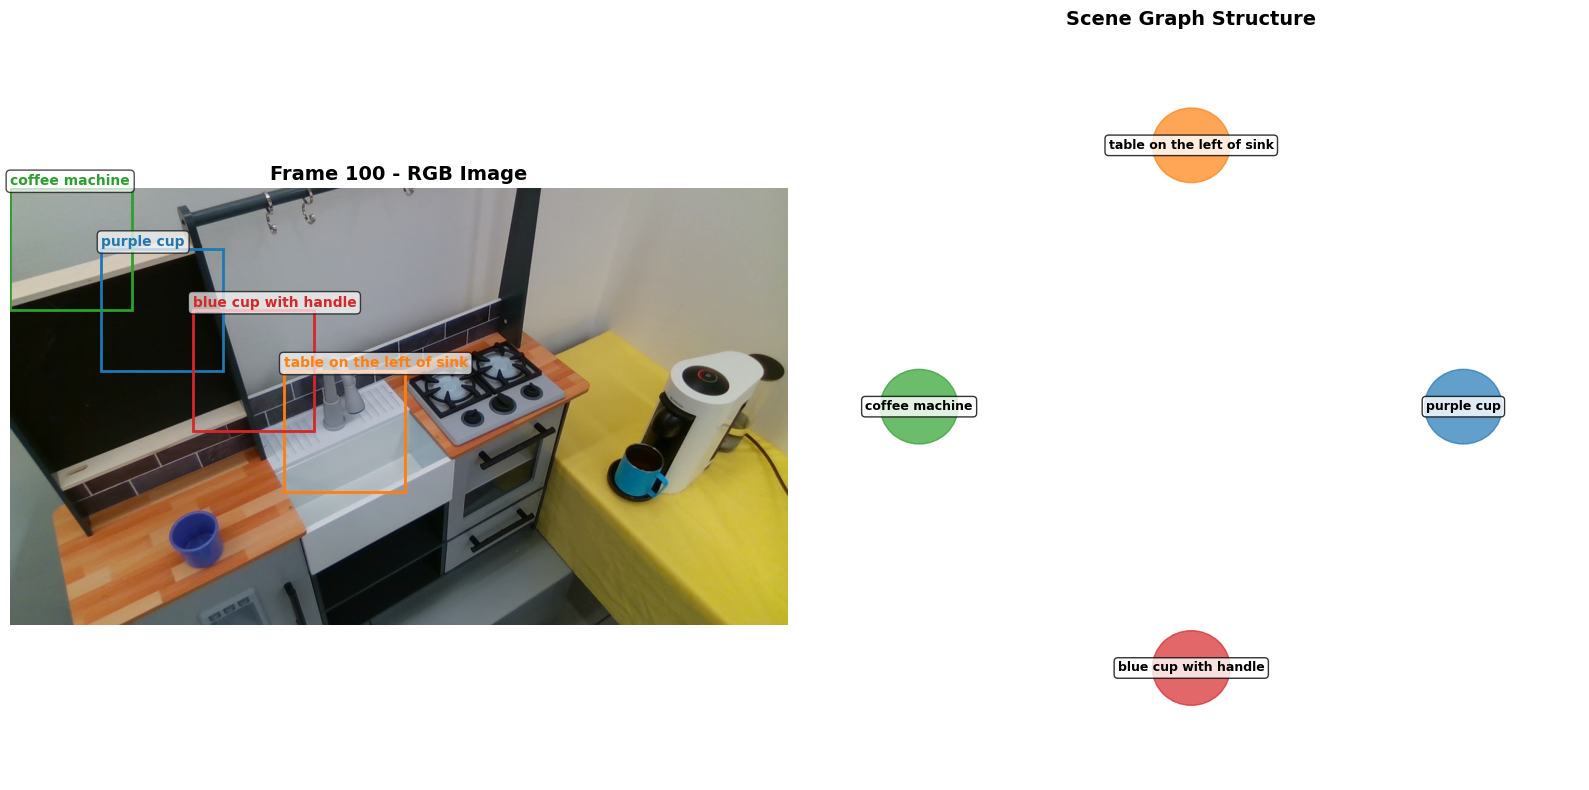


------------------------------------------------------------
Scene Graph Details:
------------------------------------------------------------
Number of nodes: 4
Number of edges: 0

Nodes:
  1. purple cup (type: purple cup)
     Position (3D): (-348.065, -153.058, 828.598)
     Point cloud centroid: (-348.065, -153.058, 828.598)
     Point cloud size: 26180 points

Edges (Relationships):
  2. table on the left of sink (type: table on the left of sink)
     Position (3D): (-131.020, 61.926, 1230.928)
     Point cloud centroid: (-131.020, 61.926, 1230.928)
     Point cloud size: 37010 points

Edges (Relationships):
  3. coffee machine (type: coffee machine)
     Position (3D): (-464.676, -244.313, 828.603)
     Point cloud centroid: (-464.676, -244.313, 828.603)
     Point cloud size: 22621 points

Edges (Relationships):
  4. blue cup with handle (type: blue cup with handle)
     Position (3D): (-286.881, -74.681, 1134.639)
     Point cloud centroid: (-286.881, -74.681, 1134.639)
     P

In [19]:
# Generate scene graph from real-world REFLECT data
if REFLECT_AVAILABLE and zarr_group is not None and task_info:
    print("\n" + "-" * 60)
    print("Generating Scene Graph from Real-World Data")
    print("-" * 60)
    
    # Initialize scene graph builder
    builder = ReflectSceneGraphBuilder(
        detector=detector,  # Use the detector we initialized earlier
        scene_analyzer=scene_analyzer,
        camera_intrinsics={
            "fx": 914.27246,
            "fy": 913.2658,
            "cx": 647.0733,
            "cy": 356.32526
        }
    )
    
    # Process a sample frame
    step_idx = 100  # Example frame index
    print(f"\nProcessing frame {step_idx}...")
    
    # Debug: Check zarr structure
    print("\nDebug: Checking zarr structure...")
    print(f"Zarr keys (first 20): {list(zarr_group.keys())[:20]}")
    if 'data' in zarr_group:
        print(f"Data keys: {list(zarr_group['data'].keys())[:10]}")
    if 'videos' in zarr_group:
        print(f"Videos keys: {list(zarr_group['videos'].keys())[:10]}")
    
    # Try to load with folder_name for file-based loading
    # Use try-except to handle both old and new method signatures
    try:
        rgb = data_loader.load_frame_rgb(zarr_group, step_idx, folder_name=folder_name)
        depth = data_loader.load_frame_depth(zarr_group, step_idx, folder_name=folder_name)
    except TypeError:
        # Fallback: try without folder_name (old signature)
        print("⚠️  Using fallback method (without folder_name parameter)")
        rgb = data_loader.load_frame_rgb(zarr_group, step_idx)
        depth = data_loader.load_frame_depth(zarr_group, step_idx)
    
    # If still None, try alternative methods
    if rgb is None:
        print(f"\n⚠️  RGB not found in zarr, trying file system...")
        # Try direct file path
        try:
            from imagecodecs import imread
            rgb_path = f"/home/fdse/zzy/reflect/reflect_dataset/real_data/{folder_name}/videos/color/{step_idx}.0.0.0"
            if os.path.exists(rgb_path):
                rgb = imread(rgb_path)
                print(f"✅ Loaded RGB from file: {rgb_path}")
            else:
                print(f"  File not found: {rgb_path}")
        except Exception as e:
            print(f"  Error: {e}")
    
    if depth is None:
        print(f"\n⚠️  Depth not found in zarr, trying file system...")
        try:
            from imagecodecs import imread
            depth_path = f"/home/fdse/zzy/reflect/reflect_dataset/real_data/{folder_name}/videos/depth/{step_idx}.0.0"
            if os.path.exists(depth_path):
                depth = imread(depth_path)
                print(f"✅ Loaded depth from file: {depth_path}")
            else:
                print(f"  File not found: {depth_path}")
        except Exception as e:
            print(f"  Error: {e}")
    
    if rgb is not None and depth is not None:
        print(f"\n✅ Successfully loaded RGB: {rgb.shape}, Depth: {depth.shape}")
        
        # Generate scene graph
        try:
            # Reset builder to start fresh (important for point cloud accumulation)
            builder.reset()
            
            # Convert RGB to PIL Image if needed
            from PIL import Image
            # Ensure numpy is available
            if 'np' not in globals():
                import numpy as np
            
            if rgb is not None:
                if isinstance(rgb, np.ndarray):
                    rgb_pil = Image.fromarray(rgb)
                else:
                    rgb_pil = rgb
            else:
                print("⚠️  RGB image is None, cannot generate scene graph")
                scene_graph = None
            
            if rgb_pil is not None:
                # Debug: Check detections before processing
                print("\nDebug: Checking detections...")
                detections = detector.detect_with_depth(
                    rgb_pil,
                    depth,
                    task_info.get('object_list', []),
                    builder.camera_intrinsics
                )
                print(f"Number of detections: {len(detections)}")
                for det in detections:
                    bbox = det['bbox']
                    print(f"  - {det['label']}: bbox={bbox}, has_mask={det.get('mask') is not None}")
                    if bbox == [0, 0, 100, 100]:
                        print(f"    ⚠️  WARNING: This object has the default mock bbox!")
                
                # Check if all bboxes are the same
                bboxes = [det['bbox'] for det in detections]
                if len(set(tuple(b) for b in bboxes)) == 1 and len(bboxes) > 1:
                    print(f"\n⚠️  CRITICAL: All objects have the same bbox: {bboxes[0]}")
                    print("   This will cause all objects to have the same 3D position!")
                    print("   Please use a real detector (MDETR) instead of the mock detector.")
                
                scene_graph = builder.process_frame(
                rgb=rgb,
                depth=depth,
                step_idx=step_idx,
                object_list=task_info.get('object_list', []),
                distractor_list=task_info.get('distractor_list', []),
                    task_info=task_info
                )
            else:
                scene_graph = None
            
            if scene_graph is not None:
                print(f"\n✅ Scene graph generated for frame {step_idx}:")
                print(scene_graph.to_text())
            
                # Debug: Check if positions are unique
                print("\n" + "-"*60)
                print("Debug: 3D Positions Check")
                print("-"*60)
                positions = []
                for node in scene_graph.nodes:
                    if node.position:
                        positions.append(node.position)
                        print(f"{node.get_name()}: {node.position}")
                
                if len(positions) > 1:
                    # Check if all positions are the same
                    unique_positions = set(positions)
                    if len(unique_positions) == 1:
                        print(f"\n⚠️  WARNING: All objects have the same 3D position: {positions[0]}")
                        print("   This indicates a problem with point cloud computation.")
                    else:
                        print(f"\n✅ Good: Found {len(unique_positions)} unique positions")
                                                # Show position differences
                        # Ensure numpy is available
                        if 'np' not in globals():
                            import numpy as np
                        for i, pos1 in enumerate(positions):
                            for j, pos2 in enumerate(positions[i+1:], i+1):
                                dist = np.linalg.norm(np.array(pos1) - np.array(pos2))
                                node1_name = list(scene_graph.nodes)[i].get_name()
                                node2_name = list(scene_graph.nodes)[j].get_name()
                                print(f"   Distance between {node1_name} and {node2_name}: {dist:.3f}m")
                
                # Visualize the scene graph
            print("\n" + "="*60)
            print("Scene Graph Visualization")
            print("="*60)
            
            # Display scene graph structure
            import matplotlib.pyplot as plt
            from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
            import matplotlib.patches as mpatches
            
            # Create visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
            
            # Prepare colors for visualization
            num_nodes = len(scene_graph.nodes)
            if num_nodes > 0:
                colors = plt.cm.tab10(range(num_nodes))
            else:
                colors = []
            
            # Left: Show RGB image with detected objects
            if rgb is not None:
                ax1.imshow(rgb)
                ax1.set_title(f'Frame {step_idx} - RGB Image', fontsize=14, fontweight='bold')
                ax1.axis('off')
                
                # Annotate detected objects on image (if bbox available)
                for node, color in zip(scene_graph.nodes, colors):
                    if hasattr(node, 'attributes') and node.attributes.get('bbox2d') is not None:
                        bbox = node.attributes['bbox2d']
                        if len(bbox) == 4:
                            rect = mpatches.Rectangle(
                                (bbox[0], bbox[1]), 
                                bbox[2]-bbox[0], 
                                bbox[3]-bbox[1],
                                linewidth=2, 
                                edgecolor=color, 
                                facecolor='none'
                            )
                            ax1.add_patch(rect)
                            ax1.text(bbox[0], bbox[1]-5, node.get_name(), 
                                    fontsize=10, color=color, fontweight='bold',
                                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
            
            # Right: Show scene graph structure
            ax2.set_xlim(-1, 1)
            ax2.set_ylim(-1, 1)
            ax2.set_title('Scene Graph Structure', fontsize=14, fontweight='bold')
            ax2.axis('off')
            
            # Layout nodes in a circle
            # numpy should already be imported, but ensure it's available
            if 'np' not in globals():
                import numpy as np
            if num_nodes > 0:
                angles = np.linspace(0, 2*np.pi, num_nodes, endpoint=False)
                node_positions = {}
                
                for i, (node, angle) in enumerate(zip(scene_graph.nodes, angles)):
                    x = 0.7 * np.cos(angle)
                    y = 0.7 * np.sin(angle)
                    node_positions[node.name] = (x, y)
                    
                    # Draw node
                    circle = plt.Circle((x, y), 0.1, color=colors[i], alpha=0.7)
                    ax2.add_patch(circle)
                    ax2.text(x, y, node.get_name(), 
                            ha='center', va='center', fontsize=9, fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
                
                # Draw edges
                for (start_name, end_name), edge in scene_graph.edges.items():
                    if start_name in node_positions and end_name in node_positions:
                        x1, y1 = node_positions[start_name]
                        x2, y2 = node_positions[end_name]
                        
                        # Draw arrow
                        arrow = FancyArrowPatch(
                            (x1, y1), (x2, y2),
                            arrowstyle='->', 
                            mutation_scale=20,
                            linewidth=2,
                            color='gray',
                            alpha=0.6,
                            connectionstyle='arc3,rad=0.1'
                        )
                        ax2.add_patch(arrow)
                        
                        # Add edge label
                        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                        ax2.text(mid_x, mid_y, edge.edge_type, 
                                fontsize=8, ha='center', va='center',
                                bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))
            
            plt.tight_layout()
            plt.show()
            
            # Print detailed scene graph information
            print("\n" + "-"*60)
            print("Scene Graph Details:")
            print("-"*60)
            print(f"Number of nodes: {len(scene_graph.nodes)}")
            print(f"Number of edges: {len(scene_graph.edges)}")
            print("\nNodes:")
            for i, node in enumerate(scene_graph.nodes, 1):
                print(f"  {i}. {node.get_name()} (type: {node.object_type})")
                if node.position:
                    print(f"     Position (3D): ({node.position[0]:.3f}, {node.position[1]:.3f}, {node.position[2]:.3f})")
                if hasattr(node, 'attributes') and 'pcd' in node.attributes:
                    pcd = node.attributes['pcd']
                    if len(pcd) > 0:
                        # Ensure numpy is available
                        if 'np' not in globals():
                            import numpy as np
                        centroid = np.mean(pcd, axis=0)
                        print(f"     Point cloud centroid: ({centroid[0]:.3f}, {centroid[1]:.3f}, {centroid[2]:.3f})")
                        print(f"     Point cloud size: {len(pcd)} points")
            
                print("\nEdges (Relationships):")
                visited_edges = set()
                for (start_name, end_name), edge in scene_graph.edges.items():
                    reverse_key = (end_name, start_name)
                    if (start_name, end_name) not in visited_edges and reverse_key not in visited_edges:
                        print(f"  - {edge.start.get_name()} --[{edge.edge_type}]--> {edge.end.get_name()}")
                        visited_edges.add((start_name, end_name))
            else:
                print("\n⚠️  Could not generate scene graph (RGB image not available)")
            
        except Exception as e:
            print(f"⚠️   Error generating scene graph: {e}")
            import traceback
            traceback.print_exc()
            print("   This may be due to missing dependencies or detector not fully configured")
    else:
        print(f"⚠️  Could not load frame {step_idx}")
        print("   RGB:", rgb is not None)
        print("   Depth:", depth is not None)
else:
    print("\n⚠️  Skipping real-world data processing (zarr file not available)")


### Option 2: Simulated Environment (AI2THOR)

Generate scene graphs from AI2THOR simulation environment, similar to REFLECT's simulation workflow.


In [17]:
# ============================================================
# Option 2: Using Simulated Environment (AI2THOR)
# ============================================================

print("\n" + "=" * 60)
print("Option 2: Simulated Environment (AI2THOR)")
print("=" * 60)

# Note: This requires AI2THOR to be installed
# pip install ai2thor

if SIMULATED_AVAILABLE:
    try:
        from ai2thor.controller import Controller
        print("\n✅ AI2THOR available")
    
    # Example: Initialize simulated environment
    # scene = "FloorPlan16"  # AI2THOR scene
    # generator = SimulatedDataGenerator(scene=scene)
    # controller = generator.initialize()
    
    # # Execute actions
    # actions = [
    #     "MoveAhead",
    #     "PickupObject",
    #     # ... more actions
    # ]
    # events = generator.execute_actions(actions)
    
    # # Generate scene graphs from events
    # builder = SimulatedSceneGraphBuilder(scene_analyzer=scene_analyzer)
    # object_list = ["Mug", "CoffeeMachine", "Sink"]
    # 
    # for step_idx, event in enumerate(events):
    #     scene_graph = builder.process_event(
    #         step_idx=step_idx,
    #         event=event,
    #         object_list=object_list,
    #         task=task_info
    #     )
    #     print(f"Frame {step_idx}: {scene_graph.to_text()}")
    
    print("\n📝 To use simulated environment:")
    print("   1. Install AI2THOR: pip install ai2thor")
    print("   2. Initialize SimulatedDataGenerator with a scene")
    print("   3. Execute actions in the simulation")
    print("   4. Use SimulatedSceneGraphBuilder to generate scene graphs from events")
    print("   5. Process events similar to REFLECT's generate_scene_graphs()")
    
else:
    print("\n⚠️  Simulated environment not available")
    print("   Install AI2THOR: pip install ai2thor")
    print("   Or use real-world data option above")


SyntaxError: invalid syntax (2022490280.py, line 43)

## Summary: Real Data vs Simulated Data

### Real-World Data (REFLECT Dataset)
- **Format**: Zarr files with RGB-D images
- **Source**: Real robot execution recordings
- **Usage**: `ReflectDataLoader` + `ReflectSceneGraphBuilder`
- **Advantages**: Real-world scenarios, actual failures
- **Requirements**: REFLECT dataset files

### Simulated Data (AI2THOR)
- **Format**: AI2THOR events with frames, depth, instance masks
- **Source**: AI2THOR simulation environment
- **Usage**: `SimulatedDataGenerator` + `SimulatedSceneGraphBuilder`
- **Advantages**: Controlled scenarios, easy failure injection
- **Requirements**: AI2THOR installation

Both approaches generate scene graphs that can be used with CRAFT's failure analysis and correction planning modules.


### REFLECT Integration Workflow

The complete workflow for using REFLECT dataset with CRAFT:

1. **Load REFLECT Data**: Use `ReflectDataLoader` to load zarr files
2. **Initialize Builder**: Create `ReflectSceneGraphBuilder` with detector and analyzer
3. **Process Frames**: For each frame:
   - Load RGB-D images from zarr
   - Detect objects using MDETR/DETIC
   - Generate point clouds from depth
   - Compute spatial relationships
   - Build scene graph
4. **Use Scene Graphs**: Feed scene graphs to failure analysis and correction planning

This approach maintains compatibility with REFLECT's data format while using CRAFT's modular architecture.
